# Data-Driven Sparse Approximation of Koopman invariant subspace

In this tutorial, we will use the algorithm from [Pan-Arnold-Duraisamy, JFM, 2021](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/sparsitypromoting-algorithms-for-the-discovery-of-informative-koopmaninvariant-subspaces/F52F03ED181023369A661EF09B57281A) to learn a sparse Koopman invariant subspace from the EDMD of the
following two-dimensional, linear system (example from [Rowley, Williams & Kevrekidis,
 _"IPAM MTWS4"_, 2014](http://helper.ipam.ucla.edu/publications/mtws4/mtws4_12328.pdf)):

$$
{\bf x}_{k+1} = \begin{bmatrix} 0.8 & -0.05\\ 0 & 0.7\end{bmatrix}{\bf x}_k,
$$
where ${\bf x} = [x, y]^T$. Polynomial functions $x^iy^j$ with $i,j\in [0,3]$ up to
order 3 are used as basis functions. The true eigenfunctions and eigenvalues can be
approximated as follows:
$$
\varphi_{ij}(x,y) \approx (0.894x - 0.447y)^i y^j\quad \text{for}\quad i,
j\in\mathbb{N}\\
\lambda_{ij} = (0.8)^i(0.7)^j
$$

**Obviously, we only need linear observables to recover this**. But now let's assume we don't know a priori. Instead, we will use polynomial features up to third degrees. Then, the goal is to learn a **small** sparse (indeed linear) representation from a **large** space spanned by the polynomial observables.

In [1]:
import pykoopman as pk
from pykoopman.common import Linear2Ddynamics
import scipy
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Collect training data

In [2]:
# Create instance of the dynamical system
sys = Linear2Ddynamics()

# Collect training data
n_pts = 51
n_int = 1
xx, yy = np.meshgrid(np.linspace(-1, 1, n_pts), np.linspace(-1, 1, n_pts))
x = np.vstack((xx.flatten(), yy.flatten()))
n_traj = x.shape[1]

X, Y = sys.collect_data(x, n_int, n_traj)

### Approximate eigenfunctions and eigenvalues using EDMD and polynomial basis functions

In [3]:
regressor = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model = pk.Koopman(observables=obsv, regressor=regressor)
model.fit(X.T, y=Y.T)

print("dimension of Koopman invariant subspace from EDMD = {}".format(len(np.diag(model.lamda))))

dimension of Koopman invariant subspace from EDMD = 10


# Let's consider sparse selecting our modes!

### First, we need some trajectories that are not in the training data

- to help us quantatively measure a goodness of Koopman eigenmode

In [4]:
# first trajectory
n_int_val = 41
n_traj_val = 1
xval = np.array([[-0.3], [-0.3]])
xval_list = []
for i in range(n_int_val):
    xval_list.append(xval)
    xval = sys.linear_map(xval)
Xval1 = np.hstack(xval_list).T

In [5]:
# second trajectory
n_int_val = 17
n_traj_val = 1
xval = np.array([[-0.923], [0.59]])
xval_list = []
for i in range(n_int_val):
    xval_list.append(xval)
    xval = sys.linear_map(xval)
Xval2 = np.hstack(xval_list).T

In [6]:
n_int_val = 23
n_traj_val = 1
xval = np.array([[-2.5], [1.99]])
xval_list = []
for i in range(n_int_val):
    xval_list.append(xval)
    xval = sys.linear_map(xval)
Xval3 = np.hstack(xval_list).T

### Good news: these validation trajectories can have arbitrarily different length

Text(0, 0.5, '$x_2$')

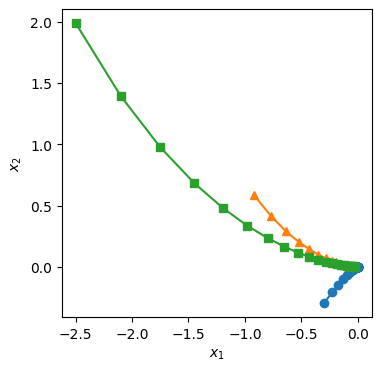

In [7]:
Xval = [Xval1, Xval2, Xval3]

plt.figure(figsize=(4,4))
plt.plot(Xval1[:,0],Xval1[:,1],'o-')
plt.plot(Xval2[:,0],Xval2[:,1],'^-')
plt.plot(Xval3[:,0],Xval3[:,1],'s-')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [8]:
# assemble the trajectories data into a dictionary
validate_data_traj = [{'t':np.arange(tmp.shape[0]), 'x':tmp} for tmp in Xval]

### Now, let's import our modes selection algorithm

In [9]:
from pykoopman.analytics import ModesSelectionPAD21

+-------+--------------------------+------------------------+------------------------+
| Index |        Eigenvalue        |           Q            |           R            |
+-------+--------------------------+------------------------+------------------------+
|   5   | (0.7000000000000014+0j)  | 1.811556114679901e-14  |  0.19796185583007808   |
|   7   | (0.3920000000000002+0j)  | 1.6009210965058542e-13 |  0.11732264585832819   |
|   0   | (1.0000000000000007+0j)  | 4.650338784995249e-14  |  0.07434205362549474   |
|   4   | (0.48999999999999955+0j) | 2.3413154744166582e-14 |  0.033433592592828514  |
|   6   | (0.3429999999999995+0j)  | 1.8412833887970327e-14 |  0.018746616231243757  |
|   3   | (0.7999999999999969+0j)  |  5.09943737939958e-15  | 4.614914991621162e-14  |
|   9   | (0.4480000000000002+0j)  | 2.0993444451119076e-14 | 3.849685323279305e-14  |
|   2   | (0.5600000000000018+0j)  | 7.713683613770912e-15  | 1.1416817512170644e-15 |
|   1   | (0.6400000000000001+0j)  | 2.3617

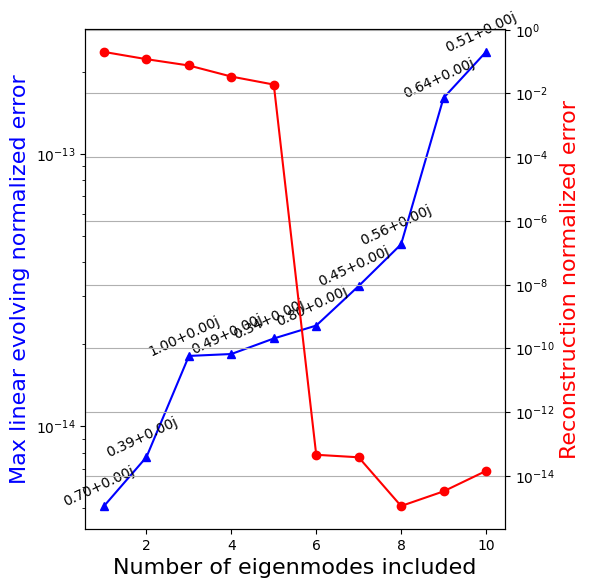

In [10]:
# feed our model, assembled data dict, and truncation threshold
analysis = ModesSelectionPAD21(model, validate_data_traj, truncation_threshold=1e-3, plot=True)

### Ok. The above figure tells me
- if I start to sparsify the modes after number 6, it will not improve the performance (of reconstruction)
- I observed that $\lambda=0.7$ is contained in the first because it has the lowest linear evolving error
- And $\lambda=0.8$ is included at number 6! this is why the reconstruction error drops quickly after 6.
- almost every eigenvalue here is excellent. simply because the linear evolving error is around machine precision

### Therefore, I am going to set $L=6$, and perform a sweeping of $\alpha$ to have a family of sparse selected solution

+-------+------------------------+------------+------------------------+
| Index |         Alpha          | # Non-zero |  Reconstruction Error  |
+-------+------------------------+------------+------------------------+
|   0   |         1e-07          |     1      |   0.6445131839387309   |
|   1   | 7.742636826811278e-07  |     1      |   0.6445131839387309   |
|   2   | 5.994842503189409e-06  |     2      |  0.12018975830516986   |
|   3   | 4.641588833612772e-05  |     2      |  0.12018975830516986   |
|   4   | 0.00035938136638046257 |     5      | 1.2921289854885476e-15 |
|   5   | 0.0027825594022071257  |     3      | 4.004954921005292e-15  |
|   6   |  0.021544346900318822  |     2      | 4.036139154041375e-15  |
|   7   |  0.16681005372000557   |     2      | 4.036139154041375e-15  |
|   8   |   1.2915496650148828   |     2      | 4.036139154041375e-15  |
|   9   |          10.0          |     2      | 4.036139154041375e-15  |
+-------+------------------------+------------+----

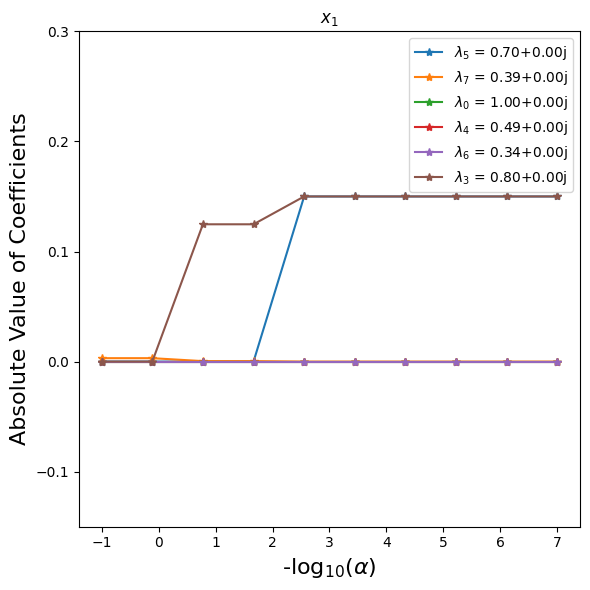

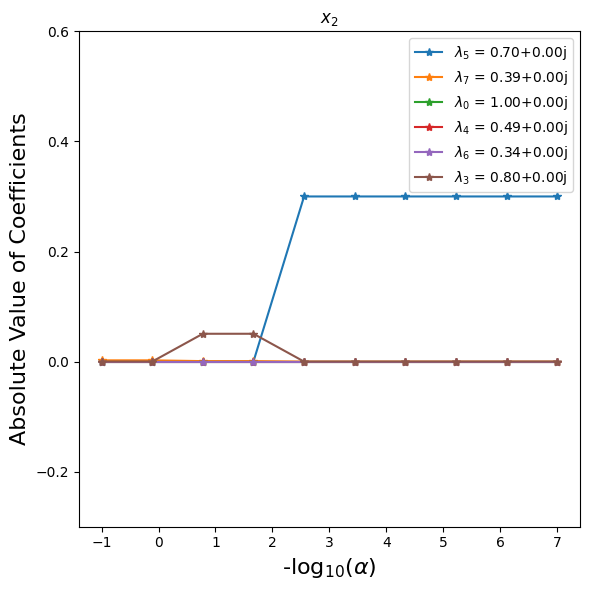

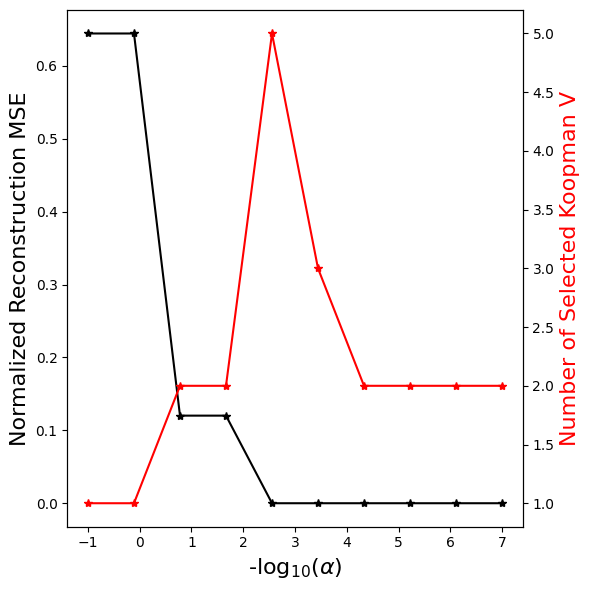

In [11]:
analysis.sweep_among_best_L_modes(L=6, ALPHA_RANGE=np.logspace(-7,1,10), save_figure=False)

### The above plot tells me 
- I just need 2 Koopman modes, I can reconstruct my validation data very well
- I should select $\alpha \approx -5$, which corresponds to the index = 6
- That is to say, the latent dimension is very likely to be 2. Of course.. we know it is a 2D linear system

### Now, let's get a pruned model

In [12]:
# you need to decide which alpha to choose, from the table above.
# and you need to feed training data (well, you could include validation 
# but here I choose to only use training data) into to the command...
pruned_model = analysis.prune_model(i_alpha=6, x_train=X.T)

## Test the performance of such reduced model on an unseen trajectory

In [13]:
# prepare testing data
n_int_val = 20
n_traj_val = 1
xval = np.array([[-1.6], [-0.5]])
xval_list = []
for i in range(n_int_val):
    xval_list.append(xval)
    xval = sys.linear_map(xval)
Xval4 = np.hstack(xval_list).T

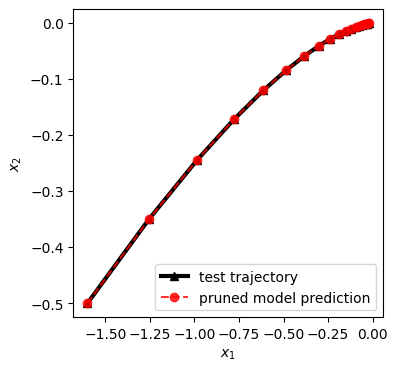

In [14]:
# run simulation on the testing data
x_ = Xval4[0:1,:]
Xval4_pred = []
for i in range(Xval4.shape[0]):
    Xval4_pred.append(x_)
    x_ = pruned_model.predict(x_)
Xval4_pred = np.vstack(Xval4_pred)


plt.figure(figsize=(4,4))
plt.plot(Xval4[:,0],Xval4[:,1],'k^-',alpha=1,label='test trajectory',lw=3)
plt.plot(Xval4_pred[:,0],Xval4_pred[:,1],'ro--',alpha=0.8,label='pruned model prediction')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend(loc='best')

## Check pruned system methods and matrix

In [15]:
# the number of Koopman modes should be only 2 modes

pruned_model.W.shape

(2, 2)

In [16]:
# compute the eigenfunction along validation trajectory Xval4, there are 2 modes after truncation with 20 snapshots

pruned_model.psi(x_col=Xval4.T).shape

(2, 20)

In [17]:
pruned_model.lamda

array([[0.7+0.j, 0. +0.j],
       [0. +0.j, 0.8+0.j]])